This notebook calculates SNR using SME metric

In [3]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

In [5]:
EEG_PATH = "/srv/eeg_reconstruction/shared/biosemi-dataset"

def get_snr_sme_results(epochs):
    # Define the time window in seconds
    # tmin, tmax = 0.1, 0.3
    tmin, tmax = 0, 1
    epsilon = 1e-10

    # We will calculate SNR, SME for each unique event in the concatenated epochs
    event_ids = epochs.event_id
    snr_results = {}
    sme_results = {}
    event_occurences = {}

    for event_id, _ in event_ids.items():
        # Select epochs for the current event_id
        epochs_specific = epochs[event_id]

        if len(epochs_specific) == 0:
            event_occurences[event_id] = 0
            continue
        
        # Get data and times, restrict to the time window of interest
        data = epochs_specific.get_data(picks='eeg')  # shape: (n_epochs, n_channels, n_times)
        times = epochs_specific.times
        time_window_mask = (times >= tmin) & (times <= tmax)
        
        # Extract the data within the specified time window
        data_in_window = data[:, :, time_window_mask]
        
        # Calculate the average ERP waveform (signal) across epochs for each time point and channel
        signal = data_in_window.mean(axis=0)
        
        # Calculate the standard deviation across epochs for each channel
        sd = np.std(data_in_window, axis=0)
        
        # Calculate N (the number of epochs for the current event_id)
        N = len(epochs_specific)
        
        # Calculate the Simple Measurement Error (SME) for each channel
        SME = sd / np.sqrt(N)
        
        # Calculate SNR for each channel at each timepoint
        SNR = np.abs(signal) / (SME + epsilon) # shape (n_channels, n_times)
        
        # Store the results
        snr_results[event_id] = SNR
        sme_results[event_id] = SME
        event_occurences[event_id] = N

    return snr_results, sme_results, event_occurences

In [6]:
# Path to the directory containing .fif files
fif_dir = os.path.join(EEG_PATH, 'final_eeg', '05_125')

# List all .fif files in the directory
fif_files = [f for f in os.listdir(fif_dir) if f.endswith('.fif')]

# Initialize an empty list to hold epochs from all files
all_epochs = []

for fif_file in fif_files:
    processed_fif_path = os.path.join(fif_dir, fif_file)
    epochs = mne.read_epochs(processed_fif_path, preload=True)
    all_epochs.append(epochs)

# Concatenate epochs from all files
concatenated_epochs = mne.concatenate_epochs(all_epochs)

# Calculate SNR and SME for each event in the concatenated epochs
snr_results, sme_results, event_occurences = get_snr_sme_results(concatenated_epochs)

Reading /srv/eeg_reconstruction/shared/biosemi-dataset/final_eeg/05_125/subj05_session1_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3662 matching events found
No baseline correction applied
0 projection items activated
Reading /srv/eeg_reconstruction/shared/biosemi-dataset/final_eeg/05_125/subj08_session1_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3774 matching events found
No baseline correction applied
0 projection items activated
Reading /srv/eeg_reconstruction/shared/biosemi-dataset/final_eeg/05_125/subj04_session1_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3635 matching events found
No baseline correction applied
0 projection items activated
Reading /srv/eeg_re

KeyboardInterrupt: 

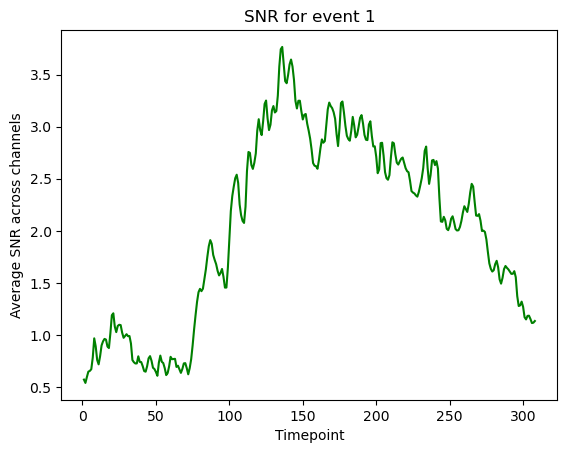

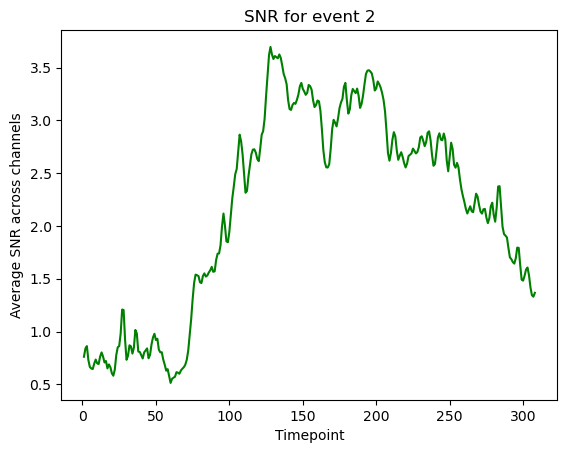

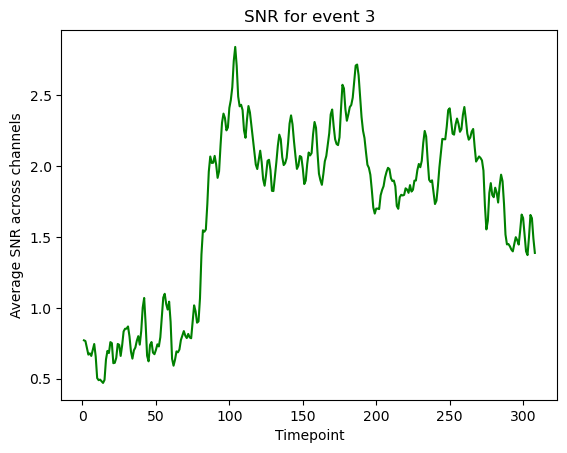

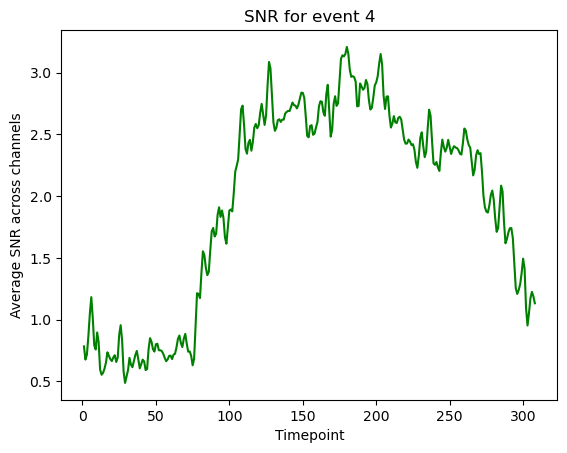

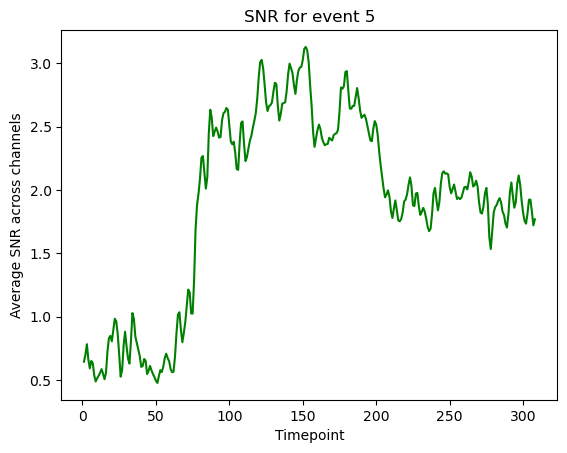

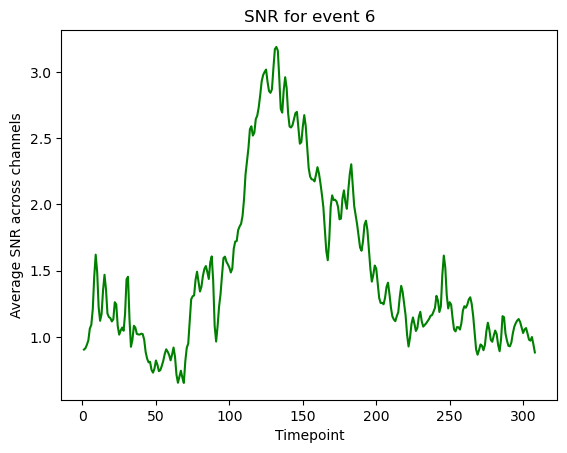

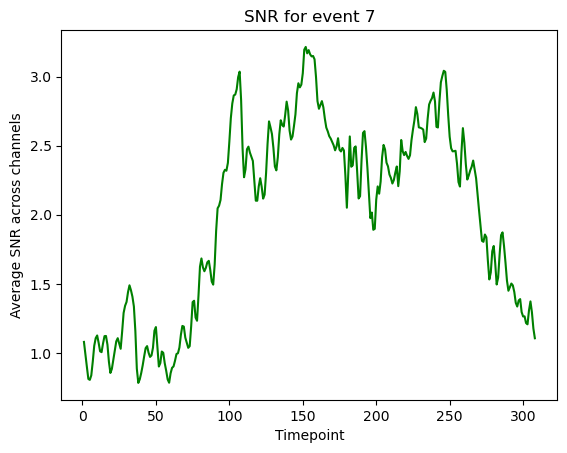

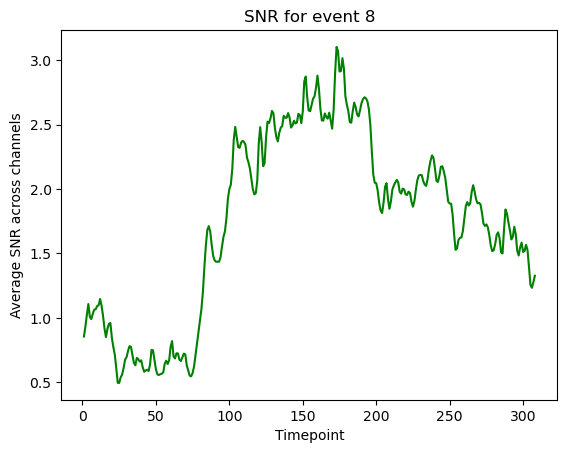

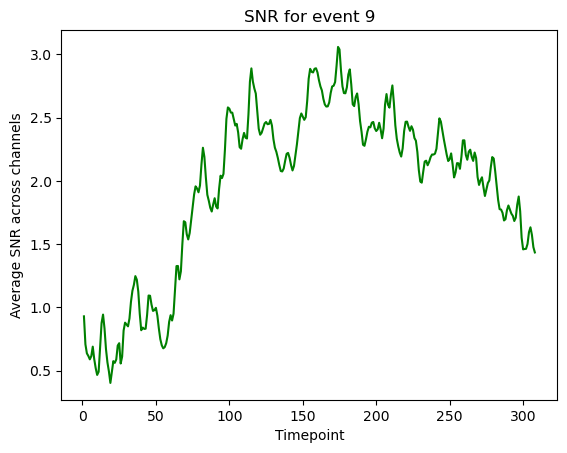

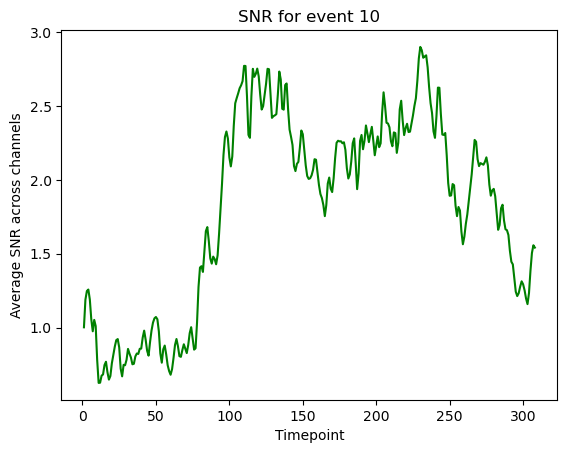

In [ ]:
# Plot the SNR for across each timepoint for events 1-10
counter = 0
for event_id, snr in snr_results.items():
    counter += 1
    if counter > 10:
        break

    average_snr_per_timepoint = list(snr.mean(axis=0))
    timepoints = [i+1 for i in range(len(average_snr_per_timepoint))] 

    plt.figure()
    plt.plot(timepoints, average_snr_per_timepoint, color='green')
    plt.xlabel('Timepoint')
    plt.ylabel('Average SNR across channels')
    plt.title(f'SNR for event {event_id}')
    plt.show()

Event Occurences: {'1': 40, '2': 41, '3': 37, '4': 40, '5': 39, '6': 34, '7': 36, '8': 39, '9': 39, '10': 39, '11': 37, '12': 40, '13': 42, '14': 42, '15': 38, '16': 44, '17': 39, '18': 38, '19': 37, '20': 34, '21': 36, '22': 38, '23': 37, '24': 35, '25': 39, '26': 31, '27': 40, '28': 37, '29': 39, '30': 41, '31': 43, '32': 40, '33': 38, '34': 37, '35': 38, '36': 38, '37': 33, '38': 40, '39': 37, '40': 39, '41': 41, '42': 37, '43': 37, '44': 39, '45': 37, '46': 39, '47': 35, '48': 41, '49': 34, '50': 38, '51': 40, '52': 32, '53': 40, '54': 38, '55': 39, '56': 35, '57': 38, '58': 34, '59': 38, '60': 39, '61': 39, '62': 39, '63': 41, '64': 39, '65': 41, '66': 41, '67': 38, '68': 37, '69': 38, '70': 33, '71': 37, '72': 40, '73': 39, '74': 37, '75': 39, '76': 39, '77': 37, '78': 36, '79': 39, '80': 32, '81': 42, '82': 36, '83': 34, '84': 42, '85': 36, '86': 35, '87': 39, '88': 36, '89': 43, '90': 41, '91': 38, '92': 39, '93': 38, '94': 36, '95': 39, '96': 33, '97': 39, '98': 35, '99': 36, 

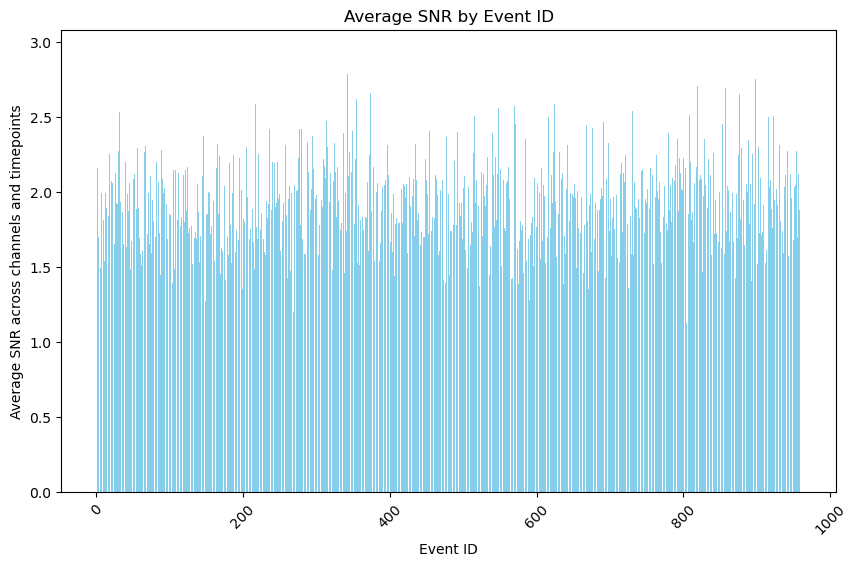

In [10]:

# Optionally, print the SME for each event_id (and each channel, if you wish)
# for event_id, SME in sme_results.items():
#     print(f"Event ID: {event_id}")
#     for i, sme_value in enumerate(SME):
#         print(f"  Channel {i+1}: SME = {sme_value}")

# Plotting SNR for a representative channel or average over channels, if preferred
# For simplicity, let's plot the average SNR across channels for each event ID
average_snr_per_event = {event_id: np.mean(SNR) for event_id, SNR in snr_results.items()}
events = list(average_snr_per_event.keys())
average_snr_values = list(average_snr_per_event.values())
print("Event Occurences:", event_occurences)

# Get the top 10 events with the highest average SNR
sorted_events = [[event_id, x, event_occurences] for event_id, x, event_occurences in sorted(zip(average_snr_values, events, event_occurences.values()), reverse=True)]
print("Top 10 events with the highest average SNR:", sorted_events[:10])

plt.figure(figsize=(10, 6))
plt.bar(list(map(lambda event: int(event), events)), average_snr_values, color='skyblue')
plt.xlabel('Event ID')
plt.ylabel('Average SNR across channels and timepoints')
plt.title('Average SNR by Event ID')
plt.xticks(rotation=45)
plt.show()


In [7]:
# Path to the directory containing .fif files
fif_dir = os.path.join(EEG_PATH, 'final_eeg', '05_125')

# List all .fif files in the directory
fif_files = [f for f in os.listdir(fif_dir) if f.endswith('.fif')]

# Getting average SNR for each subject, averaged across all event IDs and channels
session_epochs = {}

for fif_file in fif_files:
    session_id = (' ').join(fif_file.split('_')[0:2])
    processed_fif_path = os.path.join(fif_dir, fif_file)
    epochs = mne.read_epochs(processed_fif_path, preload=True)
    session_epochs[session_id] = epochs

Reading /srv/eeg_reconstruction/shared/biosemi-dataset/final_eeg/05_125/subj05_session1_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3662 matching events found
No baseline correction applied
0 projection items activated
Reading /srv/eeg_reconstruction/shared/biosemi-dataset/final_eeg/05_125/subj08_session1_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3774 matching events found
No baseline correction applied
0 projection items activated
Reading /srv/eeg_reconstruction/shared/biosemi-dataset/final_eeg/05_125/subj04_session1_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3635 matching events found
No baseline correction applied
0 projection items activated
Reading /srv/eeg_re

In [8]:
# Calculate SNR and SME for each event in the concatenated epochs
average_snr_per_session = {}

for session_id, epochs in session_epochs.items():
    print(f"Beginning calculations on {session_id}")
    snr_results, sme_results, event_occurences = get_snr_sme_results(epochs)
    print(f"Event Occurences: {event_occurences}")
    for event_id, event_occurences in event_occurences.items():
        if event_occurences == 0:
            print(f"Event ID {event_id} has 0 occurences")
    average_snr_per_event = {event_id: np.mean(SNR) for event_id, SNR in snr_results.items()}

    # Remove events with above average SNR
    removed_events = []
    for event_id, average_snr in average_snr_per_event.items():
        if average_snr > 150:
            print(f"Dropping event ID {event_id}, which has above average SNR of {average_snr}")
            removed_events.append(event_id)
    for event_id in removed_events:
        del average_snr_per_event[event_id]

    average_snr_values = list(average_snr_per_event.values())
    print(f"SNR values: {average_snr_values}")
    print(f"Session ID: {session_id}, Average SNR: {np.mean(average_snr_values)}")
    average_snr_per_session[session_id] = average_snr_values

# Printings the average SNR for each session
print("\nAverage SNR per session:")
for session_id, average_snr_values in average_snr_per_session.items():
    print(f"Session ID: {session_id}, Average SNR: {np.mean(average_snr_values)}")

Beginning calculations on subj05 session1
Event Occurences: {'1': 4, '2': 4, '3': 4, '4': 4, '5': 4, '6': 4, '7': 4, '8': 3, '9': 4, '10': 4, '11': 4, '12': 4, '13': 4, '14': 4, '15': 4, '16': 4, '17': 4, '18': 4, '19': 4, '20': 4, '21': 4, '22': 4, '23': 4, '24': 4, '25': 4, '26': 2, '27': 4, '28': 4, '29': 4, '30': 4, '31': 4, '32': 4, '33': 4, '34': 3, '35': 4, '36': 3, '37': 4, '38': 4, '39': 4, '40': 3, '41': 4, '42': 4, '43': 3, '44': 4, '45': 4, '46': 4, '47': 4, '48': 4, '49': 4, '50': 4, '51': 4, '52': 4, '53': 4, '54': 4, '55': 4, '56': 4, '57': 4, '58': 4, '59': 4, '60': 4, '61': 4, '62': 4, '63': 3, '64': 4, '65': 4, '66': 4, '67': 4, '68': 4, '69': 4, '70': 4, '71': 4, '72': 3, '73': 3, '74': 4, '75': 4, '76': 4, '77': 4, '78': 4, '79': 4, '80': 4, '81': 4, '82': 4, '83': 4, '84': 4, '85': 4, '86': 3, '87': 4, '88': 4, '89': 4, '90': 4, '91': 4, '92': 4, '93': 4, '94': 4, '95': 4, '96': 2, '97': 3, '98': 4, '99': 4, '100': 4, '101': 4, '102': 4, '103': 4, '104': 4, '105': 

Reading /srv/eeg_reconstruction/shared/biosemi-dataset/final_eeg/05_125/subj05_session1_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3662 matching events found
No baseline correction applied
0 projection items activated
Reading /srv/eeg_reconstruction/shared/biosemi-dataset/final_eeg/05_125/subj05_session2_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
2915 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6577 matching events found
Applying baseline correction (mode: mean)
SNR averaged across each session, across each block, and within each block for subject 5


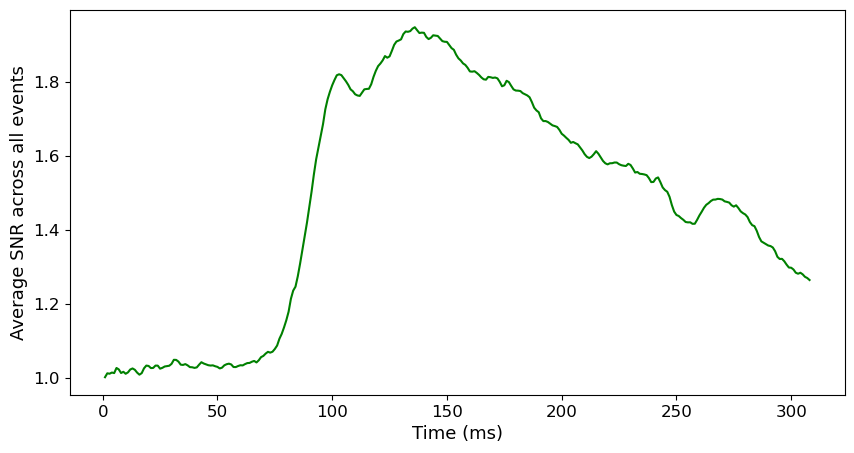

Reading /srv/eeg_reconstruction/shared/biosemi-dataset/final_eeg/05_125/subj05_session2_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
2915 matching events found
No baseline correction applied
0 projection items activated
Dropping event ID 3, which has above average SNR of 49991.687706320845
Dropping event ID 6, which has above average SNR of 48959.48745783012
Dropping event ID 47, which has above average SNR of 42893.30152347334
Dropping event ID 58, which has above average SNR of 35754.744512367506
Dropping event ID 60, which has above average SNR of 124716.99595423367
Dropping event ID 64, which has above average SNR of 221366.6443317563
Dropping event ID 71, which has above average SNR of 40423.94689293634
Dropping event ID 87, which has above average SNR of 46519.78297632842
Dropping event ID 107, which has above average SNR of 42864.94674353687
Dropping event ID 116, which has

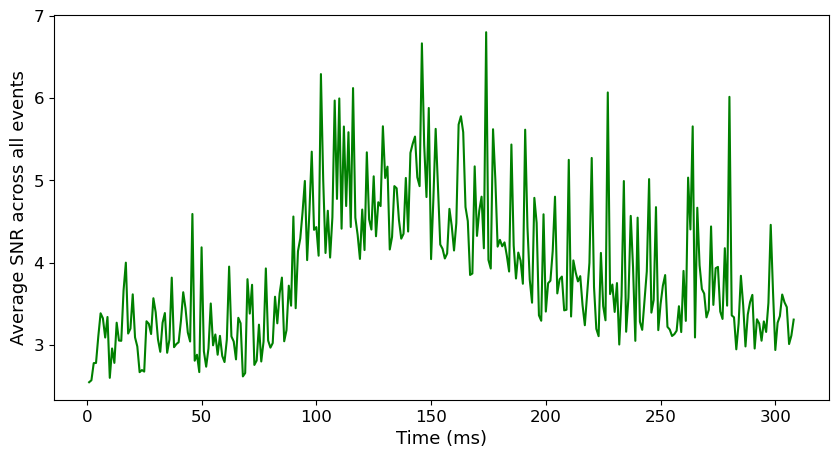

In [8]:
# Getting SNR for subject 5 across all event IDs and channels averaged across each session, across block, and within block
subj5_session_1 = os.path.join(EEG_PATH, 'final_eeg', '05_125', 'subj05_session1_epo.fif')
subj5_session_2 = os.path.join(EEG_PATH, 'final_eeg', '05_125', 'subj05_session2_epo.fif')

# 1. SNR averaged across sessions
concatenated_epochs = mne.concatenate_epochs([mne.read_epochs(subj5_session_1, preload=True), mne.read_epochs(subj5_session_2, preload=True)])
snr_results, sme_results, event_occurences = get_snr_sme_results(concatenated_epochs)

average_snr_across_all_events = np.array([list(snr.mean(axis=0)) for snr in snr_results.values()]).mean(axis=0)
timepoints = [i+1 for i in range(len(average_snr_across_all_events))]

print("SNR averaged across each session, across each block, and within each block for subject 5")
plt.figure(figsize=(10, 5))
plt.plot(timepoints, average_snr_across_all_events, color='green')
plt.xlabel('Time (ms)', fontsize=13)
plt.ylabel('Average SNR across all events', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)  # Increase the font size of the tick labels
plt.savefig('avg_snr_subj5.png')
plt.show()

# 2. SNR averaged across blocks and within each block
epochs = mne.read_epochs(subj5_session_2, preload=True)
snr_results, sme_results, event_occurences = get_snr_sme_results(epochs)

# Remove events with above average SNR
average_snr_per_event = {event_id: np.mean(SNR) for event_id, SNR in snr_results.items()}
removed_events = []
for event_id, average_snr in average_snr_per_event.items():
    if average_snr > 150:
        print(f"Dropping event ID {event_id}, which has above average SNR of {average_snr}")
        removed_events.append(event_id)
for event_id in removed_events:
    del snr_results[event_id]

average_snr_across_all_events = np.array([list(snr.mean(axis=0)) for snr in snr_results.values()]).mean(axis=0)
timepoints = [i+1 for i in range(len(average_snr_across_all_events))]

print("SNR averaged across each session, across each block, and within each block for subject 5 session 1")
plt.figure(figsize=(10, 5))
plt.plot(timepoints, average_snr_across_all_events, color='green')
plt.xlabel('Time (ms)', fontsize=13)
plt.ylabel('Average SNR across all events', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)  # Increase the font size of the tick labels
plt.savefig('avg_snr_subj5_ses1.png')
plt.show()
